# Community detection on hippocampal connections

This notebook runs the Louvain method on connections between the hippocampus and other brain regions. These connections are split into efferent (connections leaving the hippocampus) and afferent (connections entering the hippocampus). 

### Conceptual Overview:

#### Prepare the data
Filter whole-brain connectome to only include connections between hippocampal subregions and target regions  (rest of brain).

#### Construct a graph as similarity matrices
For both sets of connections, a graph is constructed, represented as an adjacency matrix.

#### Apply community detection
Determine clustering between target regions by running Louvain algorithm.

In [46]:
import numpy as np
import pandas as pd
import bct
import matplotlib.pyplot as plt

In [94]:
df_average = pd.read_csv('../data/average_connectome_data.csv', header=0, index_col=0)

In [95]:
# filter the afferent / efferent based on hippocampal connections, create similarity matrix
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus (efferent)
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]

# TO hippocampus (afferent)
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]

# drop HPC columns
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1)
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1)

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

In [96]:
df_avg_to

Abbr.,SI,MS,NDB,BSTam,BSTju,BSTrh,BSTpr,BSTif,BSTtr,BSTd,...,CLI,CS,DR,SNc,SNr,VTA,RR,PAGvm,NI,LC
DG,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,0.0,0.0,4.0,1.0,1.0,2.0,4.0
CA3,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,4.0,0.0,4.0,1.0,0.0,2.0,3.0
CA2,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
CA1v,2.0,3.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,...,0.0,0.0,2.0,4.0,0.0,4.0,3.0,0.0,2.0,2.0
CA1d,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,0.0,3.0
SUBv,2.0,5.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,2.0,0.0,1.0,3.0,2.0,3.0,3.0,0.0,2.0,1.0
SUBd,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0


In [97]:
# We will also define the hypothesis vectors
data = {
    'VENTRAL_HYPOTHESIS': [0,0,0,1,0,1,0],
    'DORSAL_HYPOTHESIS': [0,0,0,0,1,0,1],
    'CA3DG_HYPOTHESIS': [1,1,0,0,0,0,0],
    'CA1_HYPOTHESIS': [0,0,0,1,1,0,0],
    'SUB_HYPOTHESIS':[0,0,0,0,0,1,1]
}
hypothesis_df = pd.DataFrame(data, index = ['DG', 'CA3', 'CA2', 'CA1v', 'CA1d', 'SUBv', 'SUBd'])
hypothesis_df

,VENTRAL_HYPOTHESIS,DORSAL_HYPOTHESIS,CA3DG_HYPOTHESIS,CA1_HYPOTHESIS,SUB_HYPOTHESIS
DG,0,0,1,0,0
CA3,0,0,1,0,0
CA2,0,0,0,0,0
CA1v,1,0,0,1,0
CA1d,0,1,0,1,0
SUBv,1,0,0,0,1
SUBd,0,1,0,0,1


In [98]:
df_avg_from = pd.concat([df_avg_from, hypothesis_df],axis=1)
df_avg_to = pd.concat([df_avg_to, hypothesis_df],axis=1)
df_avg_to

,SI,MS,NDB,BSTam,BSTju,BSTrh,BSTpr,BSTif,BSTtr,BSTd,...,VTA,RR,PAGvm,NI,LC,VENTRAL_HYPOTHESIS,DORSAL_HYPOTHESIS,CA3DG_HYPOTHESIS,CA1_HYPOTHESIS,SUB_HYPOTHESIS
DG,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,2.0,4.0,0,0,1,0,0
CA3,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,2.0,3.0,0,0,1,0,0
CA2,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0,0,0,0,0
CA1v,2.0,3.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,...,4.0,3.0,0.0,2.0,2.0,1,0,0,1,0
CA1d,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,2.0,0.0,3.0,0,1,0,1,0
SUBv,2.0,5.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3.0,3.0,0.0,2.0,1.0,1,0,0,0,1
SUBd,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,1.0,0,1,0,0,1


In [99]:
# compute correlation matrices
# probably want to drop na columns and rows of all NaNs
spearman_df_from = (df_avg_from.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to = (df_avg_to.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

# we have to set all negative values to 0, because Louvain algirithm can't handle negatives. 
spearman_df_from[spearman_df_from<0]=0
spearman_df_to[spearman_df_to<0]=0

# Create data and labels for both afferent and efferent
efferent_connection_values = spearman_df_from.values
efferent_labels = spearman_df_from.index

afferent_connection_values = spearman_df_to.values
afferent_labels = spearman_df_to.index

In [100]:
# Run Louvain algorithm

# The gamma (γ) parameter is a resolution parameter. γ > 1 detects smaller
# communities, while γ < 1 detects larger ones. γ = 1 is the standard value.

# efferent
gamma_resolution = 1.0
community_assignments_e, modularity_score_e = bct.community_louvain(efferent_connection_values, gamma=gamma_resolution)

# afferent
community_assignments_a, modularity_score_a = bct.community_louvain(afferent_connection_values, gamma=gamma_resolution)

print(f"\nLouvain algorithm finished!")
print(f"Max modularity score - efferent (Q): {modularity_score_e:.4f}")
print(f"Max modularity score - afferent (Q): {modularity_score_a:.4f}")

# The result 'community_assignments' is an array of length 180.
# The value at each index indicates the community number for that brain region.
# Let's find out how many communities were found.
num_communities_e = len(np.unique(community_assignments_e))
num_communities_a = len(np.unique(community_assignments_a))
print(f"Number of communities found - efferent: {num_communities_e}")
print(f"Number of communities found - afferent: {num_communities_a}")


Louvain algorithm finished!
Max modularity score - efferent (Q): 0.1233
Max modularity score - afferent (Q): 0.2368
Number of communities found - efferent: 3
Number of communities found - afferent: 4


In [101]:
# Get the indices that would sort the brain regions by their community assignment.
sort_indices_e = np.argsort(community_assignments_e)
sort_indices_a = np.argsort(community_assignments_a)

# Reorder the similarity matrix using these sorted indices.
sorted_efferent_matrix = efferent_connection_values[sort_indices_e, :][:, sort_indices_e]
sorted_afferent_matrix = afferent_connection_values[sort_indices_a, :][:, sort_indices_a]

# Reorder the brain labels list to match the sorted matrix.
sorted_efferent_labels = [efferent_labels[i] for i in sort_indices_e]
sorted_afferent_labels = [afferent_labels[i] for i in sort_indices_a]

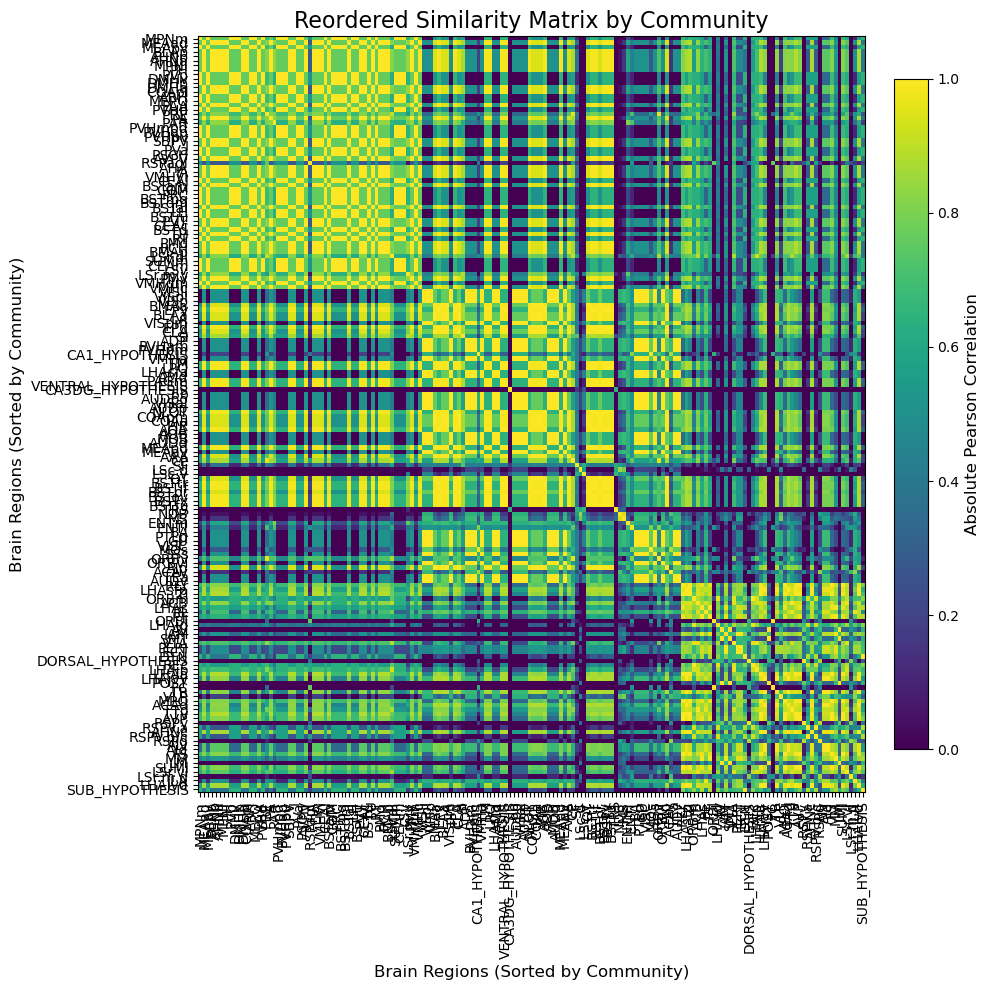

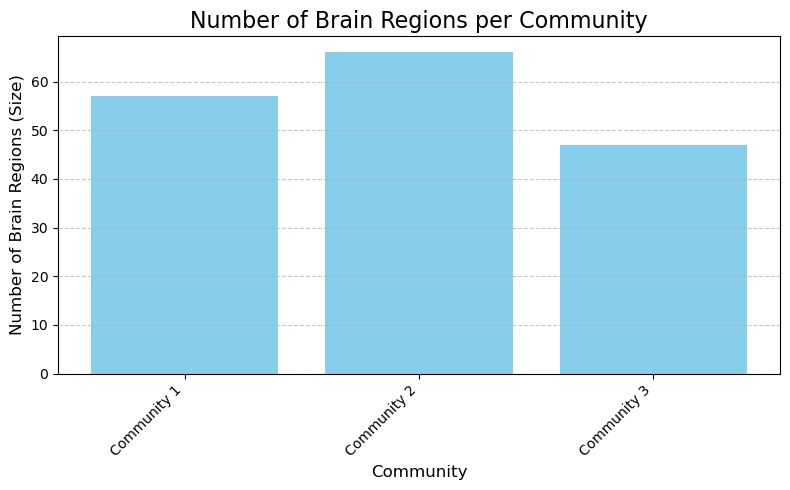

In [102]:
plt.figure(figsize=(10, 10))
im = plt.imshow(sorted_efferent_matrix, cmap='viridis', interpolation='none', aspect='auto')

plt.title('Reordered Similarity Matrix by Community', fontsize=16)
plt.xlabel('Brain Regions (Sorted by Community)', fontsize=12)
plt.ylabel('Brain Regions (Sorted by Community)', fontsize=12)

# Set the tick marks to display a subset of the labels to avoid overlap.
# We'll show every 15th label.
tick_frequency = 1
plt.xticks(np.arange(0, len(sorted_efferent_labels), tick_frequency), labels=sorted_efferent_labels[::tick_frequency], rotation=90)
plt.yticks(np.arange(0, len(sorted_efferent_labels), tick_frequency), labels=sorted_efferent_labels[::tick_frequency])

# Add a colorbar to show the mapping of colors to similarity values.
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Absolute Pearson Correlation', fontsize=12)

plt.tight_layout()
# plt.savefig('sorted_similarity_heatmap_with_labels.png')
# print("Generated and saved 'sorted_similarity_heatmap_with_labels.png'")

# B) Create the bar chart of community sizes
unique_communities, counts = np.unique(community_assignments_e, return_counts=True)
community_names = [f"Community {c}" for c in unique_communities]

plt.figure(figsize=(8, 5))
plt.bar(community_names, counts, color='skyblue')
plt.title('Number of Brain Regions per Community', fontsize=16)
plt.xlabel('Community', fontsize=12)
plt.ylabel('Number of Brain Regions (Size)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig('community_sizes_barchart.png')
# print("Generated and saved 'community_sizes_barchart.png'")

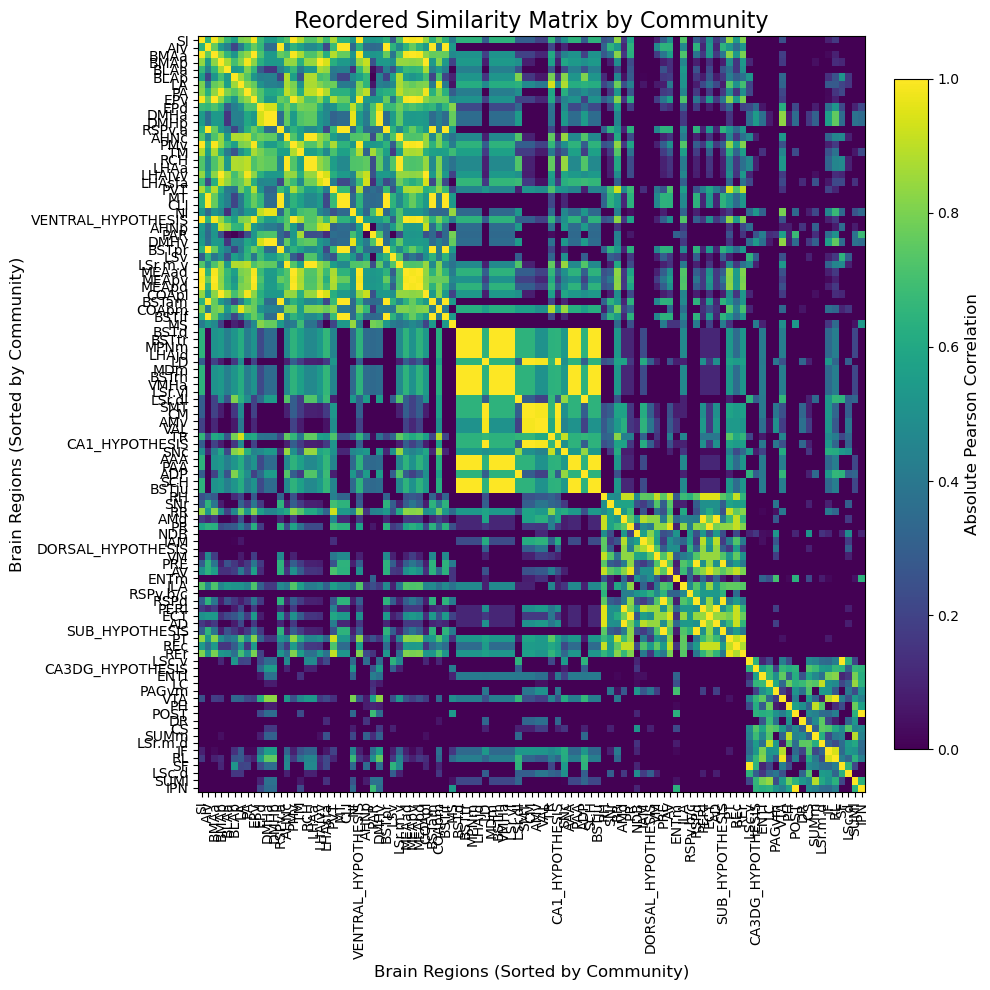

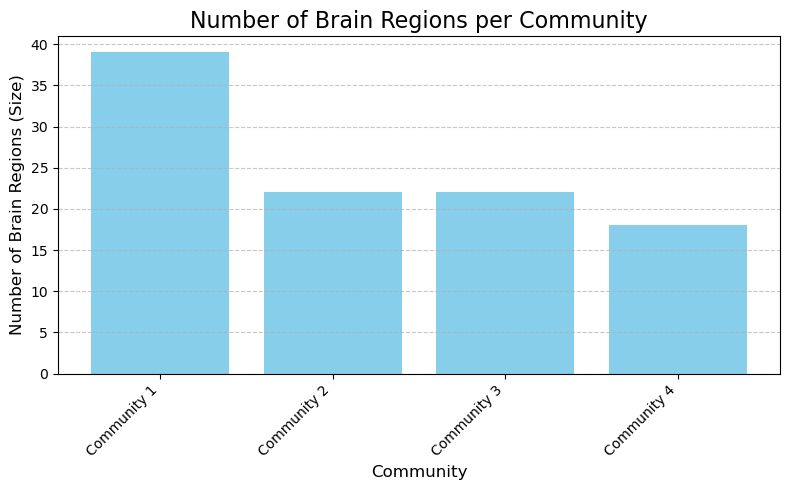

In [103]:
plt.figure(figsize=(10, 10))
im = plt.imshow(sorted_afferent_matrix, cmap='viridis', interpolation='none', aspect='auto')

plt.title('Reordered Similarity Matrix by Community', fontsize=16)
plt.xlabel('Brain Regions (Sorted by Community)', fontsize=12)
plt.ylabel('Brain Regions (Sorted by Community)', fontsize=12)

# Set the tick marks to display a subset of the labels to avoid overlap.
# We'll show every 15th label.
tick_frequency = 1
plt.xticks(np.arange(0, len(sorted_afferent_labels), tick_frequency), labels=sorted_afferent_labels[::tick_frequency], rotation=90)
plt.yticks(np.arange(0, len(sorted_afferent_labels), tick_frequency), labels=sorted_afferent_labels[::tick_frequency])

# Add a colorbar to show the mapping of colors to similarity values.
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Absolute Pearson Correlation', fontsize=12)

plt.tight_layout()
# plt.savefig('sorted_similarity_heatmap_with_labels.png')
# print("Generated and saved 'sorted_similarity_heatmap_with_labels.png'")

# B) Create the bar chart of community sizes
unique_communities, counts = np.unique(community_assignments_a, return_counts=True)
community_names = [f"Community {c}" for c in unique_communities]

plt.figure(figsize=(8, 5))
plt.bar(community_names, counts, color='skyblue')
plt.title('Number of Brain Regions per Community', fontsize=16)
plt.xlabel('Community', fontsize=12)
plt.ylabel('Number of Brain Regions (Size)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig('community_sizes_barchart.png')
# print("Generated and saved 'community_sizes_barchart.png'")

MDS transformation complete.
165


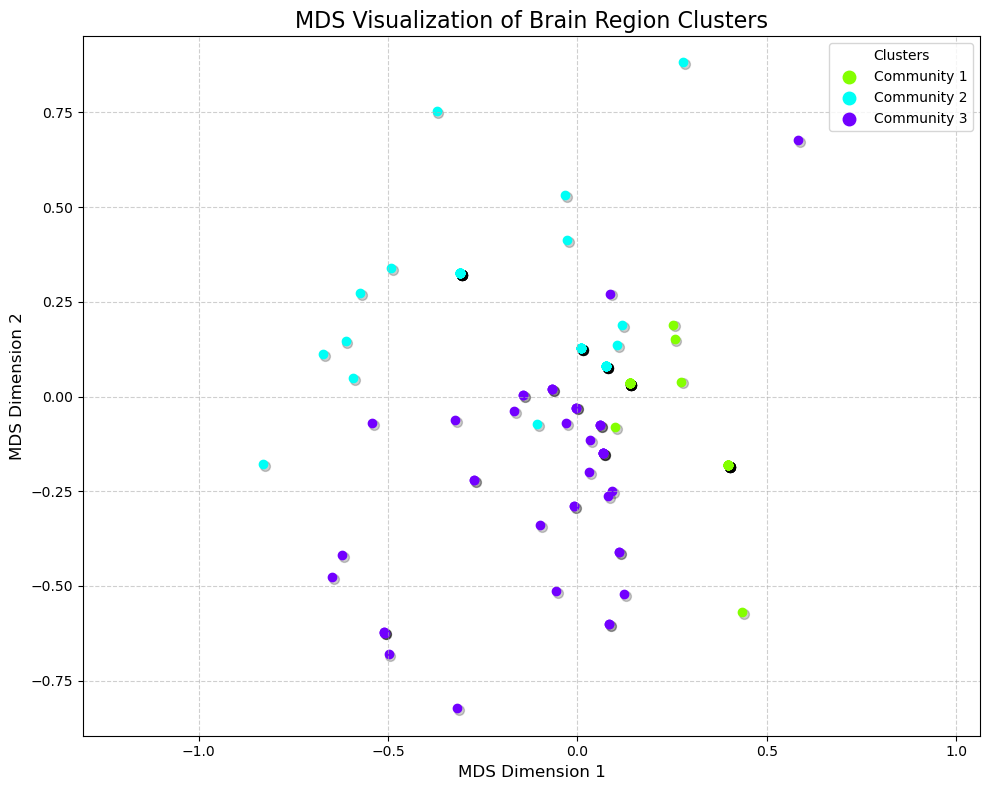

In [78]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns # Using seaborn for prettier plotting

# --- 1. Re-run Previous Steps to Get Data and Clusters ---
# (This ensures the code is self-contained)

# # Sample Data
# num_hipp_subregions = 7
# num_brain_regions = 180
# np.random.seed(42)
# efferent_connections = np.random.randint(0, 8, size=(num_hipp_subregions, num_brain_regions))

# # Similarity Matrix
# similarity_matrix = np.abs(np.corrcoef(efferent_connections.T))
# np.fill_diagonal(similarity_matrix, 0)

# # Clustering
# n_clusters = 5
# sc = SpectralClustering(n_clusters, affinity='precomputed', assign_labels='kmeans', random_state=0)
# community_assignments = sc.fit_predict(similarity_matrix)
# print(f"Using the {n_clusters} communities found by Spectral Clustering.")

# # --- 2. Perform Multidimensional Scaling (MDS) ---

# MDS works with dissimilarity, which is the inverse of similarity.
dissimilarity_matrix = 1 - efferent_connection_values

# Initialize MDS. We are projecting from 180 dimensions down to 2.
# 'precomputed' means we are providing our own distance matrix.
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0, n_init=4, max_iter=300)

# Get the 2D coordinates for each brain region
coords_2d = mds.fit_transform(dissimilarity_matrix)
print("MDS transformation complete.")


# --- 3. Visualize the MDS Plot ---

plt.figure(figsize=(10, 8))
# Create a color palette for the clusters
palette = sns.color_palette("hsv", num_communities_e)

num_points = 0

shadow_color = 'black'
shadow_alpha = 0.2 # Transparency of the shadow
shadow_offset_x = 0.005 # How much to shift the shadow horizontally
shadow_offset_y = -0.005 # How much to shift the shadow vertically

# Plot each community's points with a different color and label
for i in range(num_communities_e):
    c = i+1
    
    # Get the coordinates for the regions in the current community
    community_coords = coords_2d[community_assignments_e == c]
    num_points += len(community_coords)

    # --- ADD SHADOWS ---
    # First, plot the shadows slightly offset and with low alpha
    plt.scatter(
        community_coords[:, 0] + shadow_offset_x, 
        community_coords[:, 1] + shadow_offset_y,
        c=shadow_color,
        s=50,
        alpha=shadow_alpha
    )
    
    plt.scatter(
        community_coords[:, 0], 
        community_coords[:, 1],
        c=[palette[i]], # Use list of color tuple to avoid warning
        label=f'Community {c}'
        # s=50, # point size
        # alpha=0.8 # point transparency
    )

print(num_points)

plt.title('MDS Visualization of Brain Region Clusters', fontsize=16)
plt.xlabel('MDS Dimension 1', fontsize=12)
plt.ylabel('MDS Dimension 2', fontsize=12)
plt.legend(title='Clusters', markerscale=1.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensure scaling is the same on both axes

plt.tight_layout()
 # plt.savefig('mds_cluster_visualization.png')
# print("Generated and saved 'mds_cluster_visualization.png'")

In [68]:
coords_2d[community_assignments_e == 2][:,1]

array([ 0.18869286,  0.14626926,  0.1113547 ,  0.88347096,  0.07957871,
        0.07957871,  0.07957871,  0.12695891,  0.07957871,  0.07957871,
        0.12695891,  0.75378242, -0.17756232,  0.27241784,  0.13670322,
        0.12695891,  0.32530416,  0.07957871,  0.32530416,  0.32530416,
        0.32530416,  0.07957871,  0.12695891,  0.12695891,  0.12695891,
        0.07957871,  0.41428407,  0.53247938,  0.04826924,  0.12695891,
        0.32530416,  0.32530416, -0.07236946,  0.32530416,  0.33806708,
        0.32530416,  0.32530416,  0.32530416,  0.32530416,  0.32530416,
        0.32530416,  0.32530416,  0.32530416,  0.32530416,  0.32530416,
        0.32530416,  0.32530416,  0.12695891,  0.12695891,  0.12695891,
        0.07957871,  0.07957871,  0.12695891,  0.32530416,  0.32530416,
        0.32530416,  0.32530416,  0.32530416,  0.07957871,  0.07957871,
        0.32530416,  0.32530416,  0.07957871])

In [69]:
coords_2d[community_assignments_e == 2]

array([[ 0.1189156 ,  0.18869286],
       [-0.61201044,  0.14626926],
       [-0.67151774,  0.1113547 ],
       [ 0.28021107,  0.88347096],
       [ 0.07573993,  0.07957871],
       [ 0.07573993,  0.07957871],
       [ 0.07573993,  0.07957871],
       [ 0.01005416,  0.12695891],
       [ 0.07573993,  0.07957871],
       [ 0.07573993,  0.07957871],
       [ 0.01005416,  0.12695891],
       [-0.37156405,  0.75378242],
       [-0.82931237, -0.17756232],
       [-0.57441688,  0.27241784],
       [ 0.10489002,  0.13670322],
       [ 0.01005416,  0.12695891],
       [-0.30968189,  0.32530416],
       [ 0.07573993,  0.07957871],
       [-0.30968189,  0.32530416],
       [-0.30968189,  0.32530416],
       [-0.30968189,  0.32530416],
       [ 0.07573993,  0.07957871],
       [ 0.01005416,  0.12695891],
       [ 0.01005416,  0.12695891],
       [ 0.01005416,  0.12695891],
       [ 0.07573993,  0.07957871],
       [-0.02827701,  0.41428407],
       [-0.03339893,  0.53247938],
       [-0.59271493,